The objective of this study is to examine various methods of handling null values in 
dataset and their impact on ML algorithms final performance. 

Because dataset has no null values, I will randomly remove 25% of values from 'alcohol' column

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

from scipy import stats

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from xgboost import XGBClassifier, plot_importance, plot_tree

from sklearn.metrics import (confusion_matrix, f1_score, recall_score, precision_score,
                             mean_squared_error, classification_report, make_scorer)

def scale_split(dataframe):
    '''scale dataframe input with sklearn's Robust Scaler
    splits into training and test data and returns dictonary where key is name
    this part of data and value is scaled splitted data'''
    scaled_data = {}
    
    X = df.drop('quality', axis=1)
    y = df.loc[:,'quality']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=34)
    
    scaler = RobustScaler()
    scaled_data['X_train'] = scaler.fit_transform(X_train)
    scaled_data['X_test'] = scaler.transform(X_test)

    scaled_data['y_train'] = y_train
    scaled_data['y_test'] = y_test
    
    return scaled_data

def fill_with_imputer(data, fill_method):
    '''function takes mumpy array data and null fill method as an inpute
    performs sklearn's simple imputer on this data and returns not-null numpy array'''
    filled = {}

    imp = SimpleImputer(strategy=fill_method)
    X_train = imp.fit_transform(data['X_train'])
    X_test = imp.transform(data['X_test'])

    return X_train, X_test

def train_predict(data, algorithm):
    '''function takes as an input dictionary returned by above declared function fill_with_imputer
    and name of the algorithm which is class name, for example 'XGBClassifier()'
    trains algorithm and make predictions
    function returns tuple containing in order: train predictions, test predictions, and trained model'''
    
    if algorithm.__class__.__name__ == 'XGBClassifier': # logistic regression here does not require tuning
        algorithm = tune_xgb_parameters(data, algorithm) 
 
    algorithm.fit(data['X_train'], data['y_train'])
    
    train_preds = algorithm.predict(data['X_train'])
    test_preds = algorithm.predict(data['X_test'])
    
    return train_preds, test_preds, algorithm

def tune_xgb_parameters(data, algorithm):
    #tunes xgboost parameters with randomized search and returns bez estimator
    params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.2, 2, 5, 10, 100],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7],
        'eta': [0.01, 0.1, 0.2]
        }
    
    scorer = make_scorer(f1_score, average='binary')
    random_search = RandomizedSearchCV(algorithm, params, scoring=scorer, cv=3, n_iter=6, random_state=34)
    random_search.fit(data['X_train'], data['y_train'])
    
    return random_search.best_estimator_

def get_f1_from_predictions(fill_method, model):
    '''function takes as an input null fill method and dictionary with model name
    as a key and its train and test predictions as a values. Returns dataframe
    with model and its train and test f1.
    Allowed algorithms are XGBClassifier and Logistic Regression
    '''
    
    
    df = pd.DataFrame(columns=['algorithm', 'train_f1','test_f1'])
    
    xgb_train_preds = model['XGBClassifier_train_preds']
    xgb_test_preds = model['XGBClassifier_test_preds']
    
    lr_train_preds = model['LogisticRegression_train_preds']
    lr_test_preds = model['LogisticRegression_test_preds']
    
    y_test_true = preprocessed[fill_method]['y_test']
    y_train_true = preprocessed[fill_method]['y_train']
    
    
    
    row1 = {
        'algorithm': 'XGBoost', 
        'train_f1': f1_score(y_train_true, xgb_train_preds),#, average='binary'),
        'test_f1': f1_score(y_test_true, xgb_test_preds)#, average='binary')
    }
    
    row2 = {
        'algorithm': 'LogRegression', 
        'train_f1': f1_score(y_train_true, lr_train_preds),#, average='binary'),
        'test_f1': f1_score(y_test_true, lr_test_preds)#, average='binary')
    }
    
    df = df.append(row1, ignore_index=True)
    df = df.append(row2, ignore_index=True)

    return df

df = pd.read_csv('winequality-red.csv', sep=';')

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


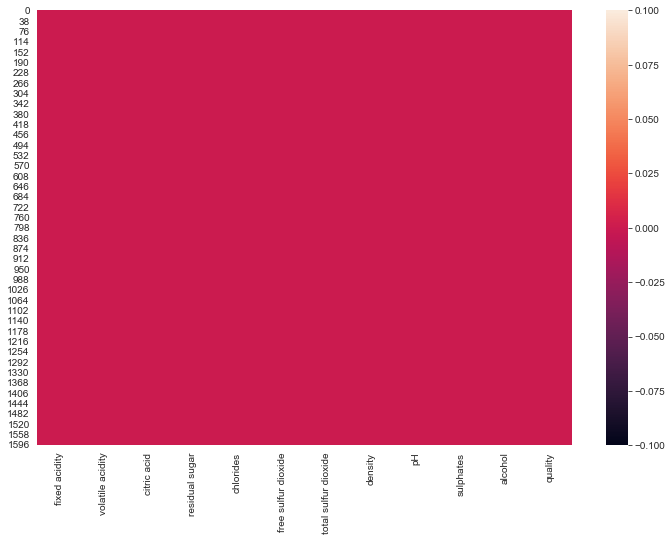

In [2]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isna())

In [3]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [5]:
df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

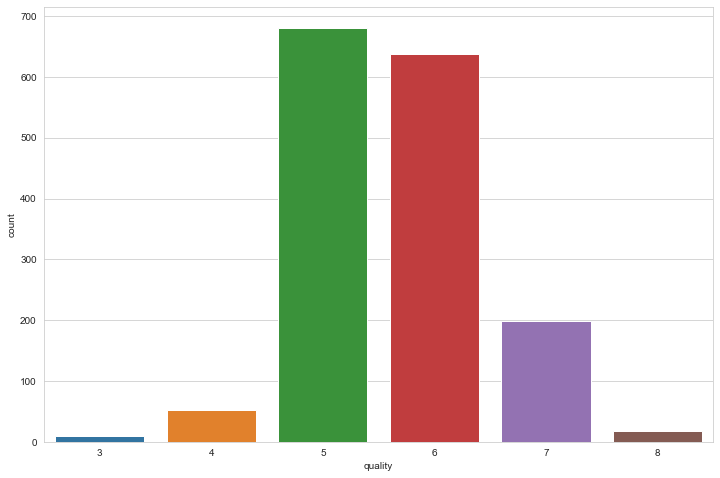

In [6]:
plt.figure(figsize=(12, 8))
sns.countplot(df['quality'])

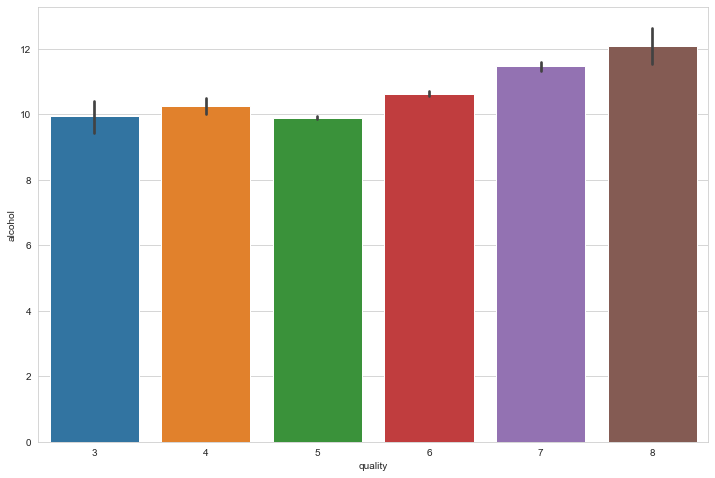

In [7]:
plt.figure(figsize=(12, 8))
sns.barplot(df['quality'], df['alcohol'])

In [8]:
#replace 25% of values from alcohol column with null values
np.random.seed(12)
random_rows = np.random.randint(0, len(df), int(len(df)/4))
for random_row in random_rows:
    df.loc[random_row, 'alcohol'] = np.nan

#classes are significantly unbalanced, this makes it hard to have well trained model
#because of it create classes which in in general mean 'high' and 'low' quality wine
df['temp'] = df['quality'].apply(lambda x: 0 if x in [3,4,5] else 1)
df['quality'] = df['temp']
df.drop('temp', inplace=True, axis=1)

preprocessed = {
    'median_filled': df,
    'mean_filled': df,
    'mode_filled': df,
    'column_dropped': df,
    'linear_regression_filled': df
               }

for fill_method, df in preprocessed.items():
    preprocessed[fill_method] = scale_split(df)

In [9]:
#Create 5 different datasets with differently handled nulls

imputer_fill_methods = ['median_filled', 'mean_filled', 'mode_filled']
aggregates = ['median', 'mean', 'most_frequent']

for fill_method, aggregate in dict(zip(imputer_fill_methods, aggregates)).items():
    
    X_train, X_test = fill_with_imputer(preprocessed[fill_method], aggregate)
    preprocessed[fill_method]['X_train'], preprocessed[fill_method]['X_test'] = X_train, X_test

coldropped_train = preprocessed['column_dropped']['X_train']
coldropped_test = preprocessed['column_dropped']['X_test']

preprocessed['column_dropped']['X_train'] = coldropped_train[:,:-1]
preprocessed['column_dropped']['X_test'] = coldropped_test[:,:-1]

lr_X_train = preprocessed['linear_regression_filled']['X_train']
lr_X_test = preprocessed['linear_regression_filled']['X_test']
lr_y_train = preprocessed['linear_regression_filled']['y_train']
lr_y_test = preprocessed['linear_regression_filled']['y_test']

#get training and test set for linear regression from only training set used for quality preds
alc_X = lr_X_train[:,:-1]
alc_y = lr_X_train[:,-1]

together = np.hstack((alc_X, alc_y.reshape(-1, 1)))

mask = np.any(np.isnan(together), axis=1)
together = together[~mask]

alc_X = together[:,:-1]
alc_y = together[:,-1]

alc_X_train, alc_X_test, alc_y_train, alc_y_test = train_test_split(alc_X, alc_y)
lin_reg = LinearRegression()

lin_reg.fit(alc_X_train, alc_y_train)

test_preds = lin_reg.predict(alc_X_test)
train_preds = lin_reg.predict(alc_X_train)

print('\ntrain MSE', mean_squared_error(alc_y_train, train_preds))
print('\ntest MSE', mean_squared_error(alc_y_test, test_preds))
#model is well trained, has good MSE results

mask = np.any(np.isnan(lr_X_train), axis=1)

train_preds = lin_reg.predict(lr_X_train[mask][:,:-1])

idx = np.where(mask)[0]
lr_X_train[idx, -1] = train_preds

mask = np.any(np.isnan(lr_X_test), axis=1)

test_preds = lin_reg.predict(lr_X_test[mask][:,:-1])
idx = np.where(mask)[0]

lr_X_test[idx, -1] = test_preds

preprocessed['linear_regression_filled']['X_train'] = lr_X_train
preprocessed['linear_regression_filled']['X_test'] = lr_X_test


train MSE 0.15799805051215873

test MSE 0.1515867684530015


In [ ]:
predictions = {}
trained_models = {}
for fill_method, data in preprocessed.items():
    model_preds = {}
    
    for algorithm in [LogisticRegression(), XGBClassifier()]: 
        
        train_preds, test_preds, model = train_predict(data, algorithm)
        model_preds[algorithm.__class__.__name__ + '_train_preds'] = train_preds
        model_preds[algorithm.__class__.__name__ + '_test_preds'] = test_preds

    predictions[fill_method] = model_preds
    trained_models[fill_method] = model

[22:53:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:53:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:53:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:53:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [ ]:
f1_scores = {}
for fill_method, prediction in predictions.items():
    f1_scores[fill_method] = get_f1_from_predictions(fill_method, prediction)
    
for fill_method, score in f1_scores.items():
    print('\n', fill_method,'\n', score)

In [ ]:
best_model = trained_models['linear_regression_filled']

In [ ]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30,20),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)

feat_importances = pd.Series(best_model.feature_importances_, index=df.drop('quality', axis=1).columns)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
fig, axes = plt.subplots()

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plot_tree(best_model, ax=axes, fmap='map.txt')
plt.show()

# CONCLUSIONS

In above experiment best way to handle null values was applying linear regression on the other columns (excluding 'quality' column).

This may be the way the best way to handle null values, however it may be unefficient in real world business task because of difficulties that comes with necessity of maintaining model